In [1]:


import json
import os
from collections import defaultdict

def analyze_mmlu_pro_ratings(base_rating : int =7):
    """
    Analyze MMLU-Pro questions based on LLM judge ratings for free-form answerability.
    Prints statistics on how many questions remain at different rating thresholds.
    """
    # Path to the MMLU-Pro question hash file
    file_path = "/fast/nchandak/qaevals/filter/mmlupro/MMLU-Pro_question_hash.jsonl"
    
    # Check if file exists
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return
    
    # Load the data
    questions = []
    with open(file_path, 'r') as f:
        for line in f:
            questions.append(json.loads(line))
    
    print(f"Loaded {len(questions)} questions from MMLU-Pro dataset")
    
    # Count questions with valid ratings
    valid_ratings = 0
    rating_distribution = defaultdict(int)
    
    for question in questions:
        question_id = list(question.keys())[0]
        if "llm_judge_fine" in question[question_id]:
            valid_ratings += 1
            rating = question[question_id]["llm_judge_fine"]
            rating_distribution[rating] += 1
    
    print(f"Found {valid_ratings} questions with LLM judge ratings")
    # Calculate and print statistics for different thresholds
    thresholds = [7, 8, 9]
    for threshold in thresholds:
        count = sum(rating_distribution[rating] for rating in rating_distribution if rating >= threshold)
        percentage = (count / valid_ratings * 100) if valid_ratings > 0 else 0
        print(f"Rating >= {threshold}: {count} questions ({percentage:.2f}% of rated questions)")
    
    # Filter questions with rating >= 8
    filtered_questions = []
    for question in questions:
        question_id = list(question.keys())[0]
        if "llm_judge_fine" in question[question_id] and question[question_id]["llm_judge_fine"] >= base_rating:
            filtered_questions.append(question_id)
            
    return filtered_questions


    

Loaded 12032 questions from MMLU-Pro dataset
Loaded 12032 samples from Qwen3-14B output
Found 12032 questions with rating >= 0
Category distribution: Counter({'math': 1351, 'physics': 1299, 'chemistry': 1132, 'law': 1101, 'engineering': 969, 'other': 924, 'economics': 844, 'health': 818, 'psychology': 798, 'business': 789, 'biology': 717, 'philosophy': 499, 'computer science': 410, 'history': 381})
Found 8578 questions with rating >= 7
Category distribution: Counter({'math': 1216, 'physics': 1211, 'chemistry': 1062, 'engineering': 893, 'business': 632, 'biology': 572, 'economics': 535, 'law': 523, 'psychology': 486, 'health': 404, 'other': 365, 'computer science': 255, 'philosophy': 250, 'history': 174})
Found 5544 questions with rating >= 8
Category distribution: Counter({'physics': 1028, 'math': 984, 'chemistry': 922, 'engineering': 676, 'business': 431, 'biology': 338, 'economics': 256, 'psychology': 193, 'other': 165, 'law': 153, 'health': 152, 'computer science': 138, 'philosophy'

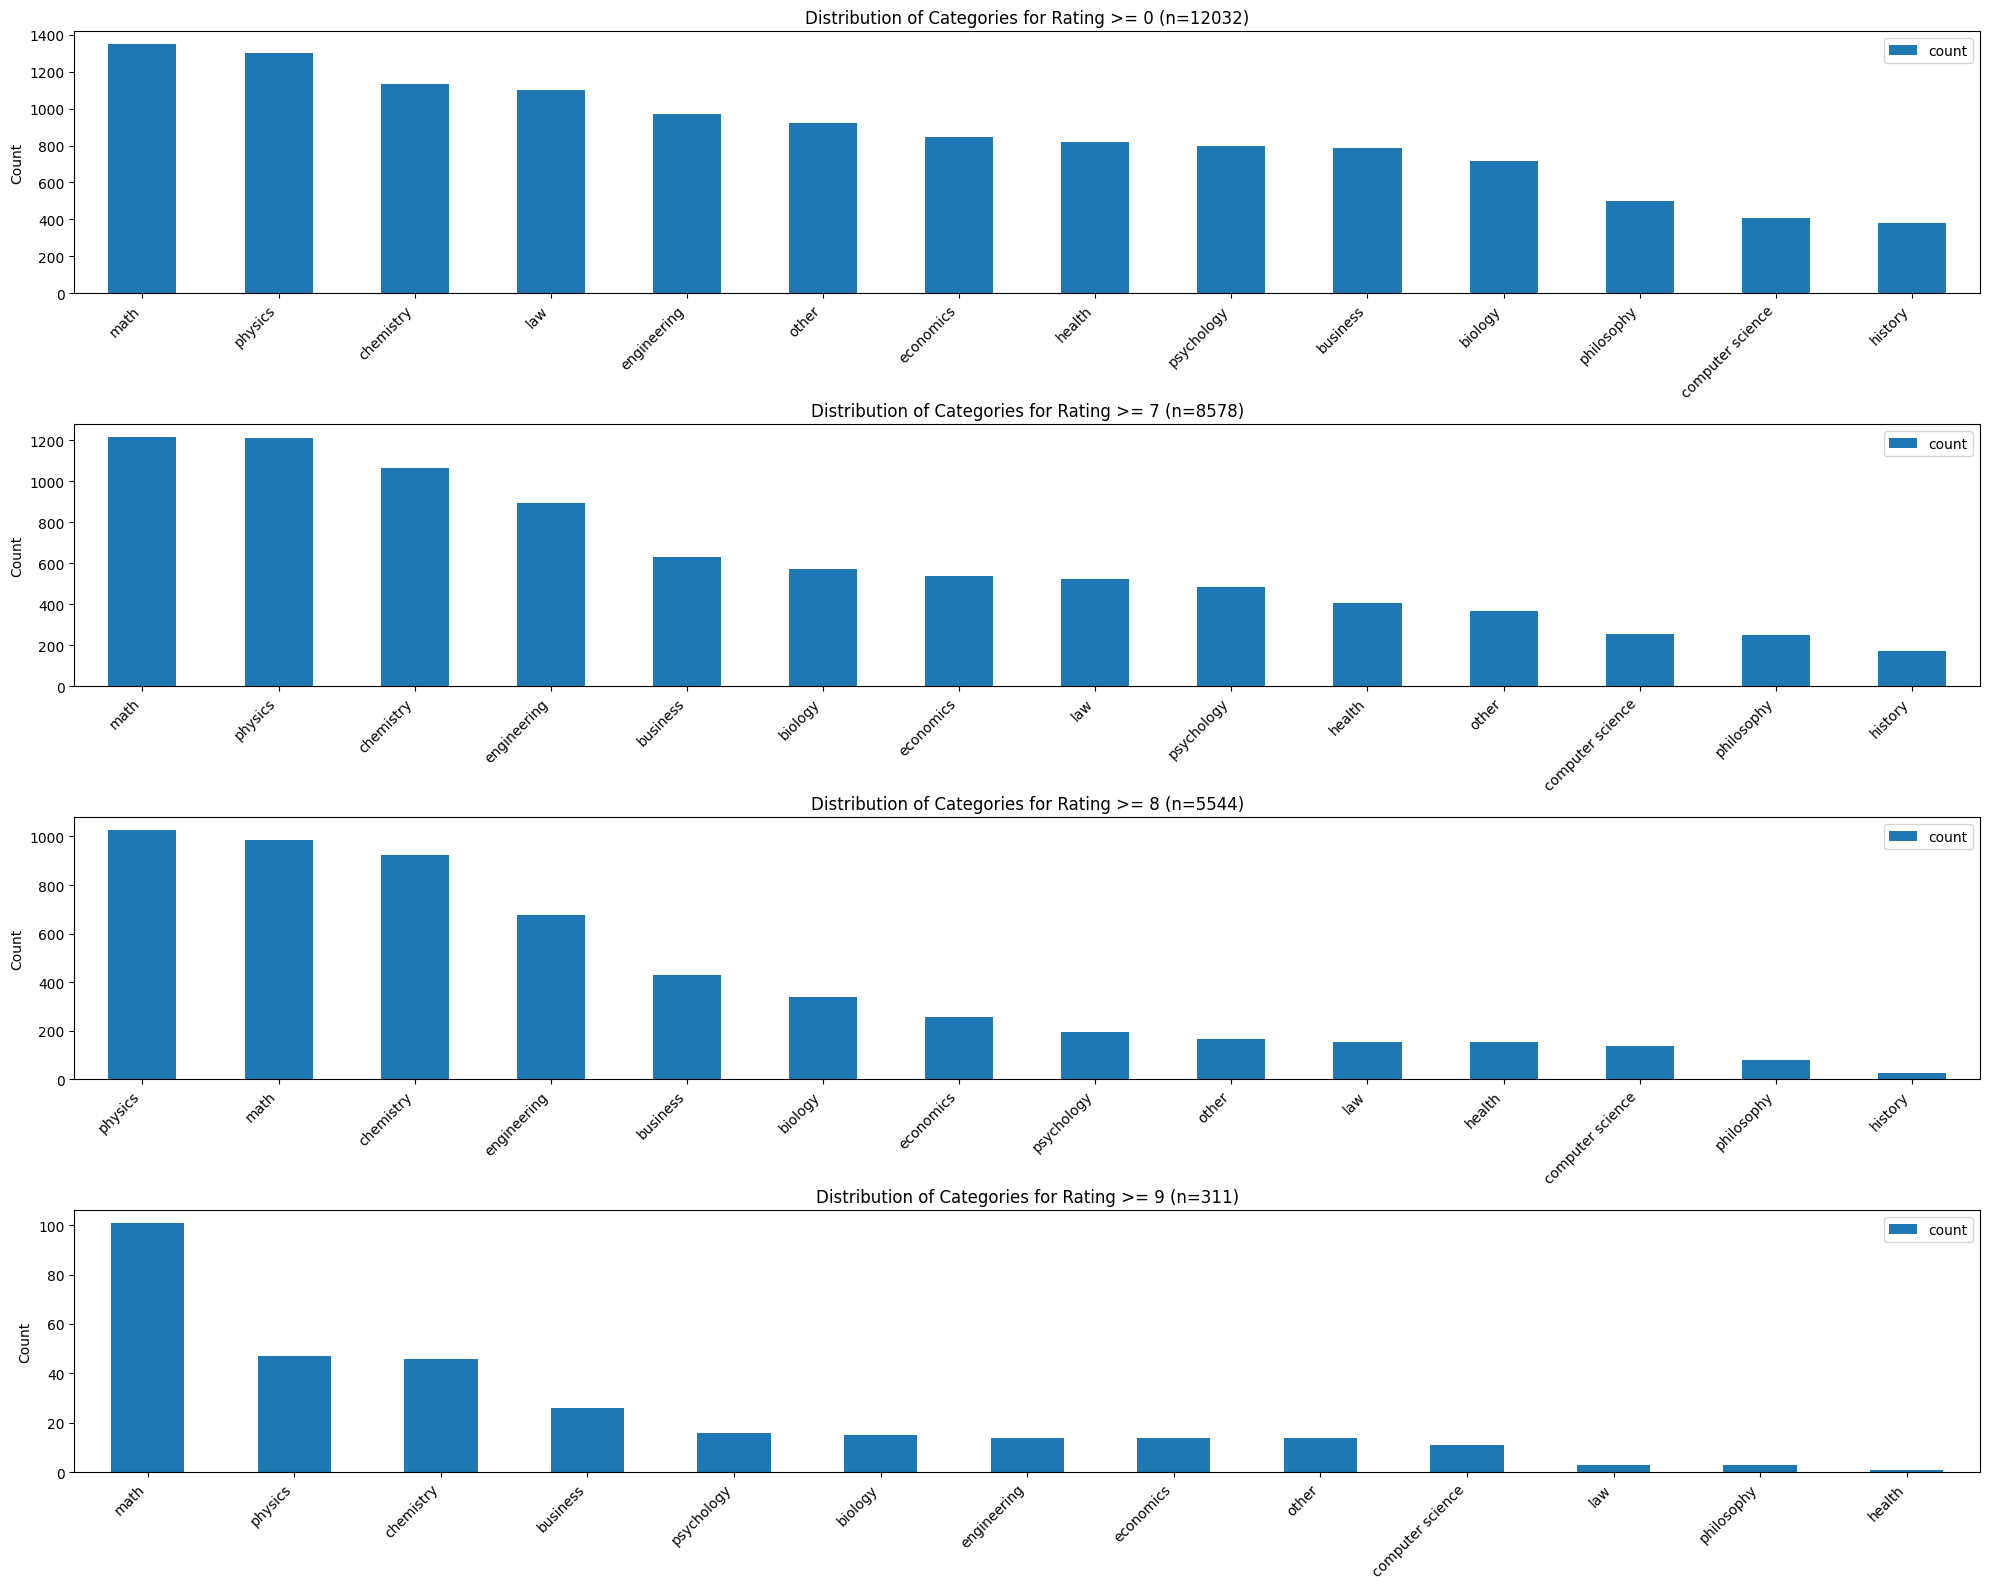

In [19]:
# Analyze distribution by rating and category
import json
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
# Load the MMLU-Pro questions for IDs and ratings
file_path = "/fast/nchandak/qaevals/filter/mmlupro/MMLU-Pro_question_hash.jsonl"
questions = []

try:
    with open(file_path, 'r') as f:
        for line in f:
            questions.append(json.loads(line))
    print(f"Loaded {len(questions)} questions from MMLU-Pro dataset")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    questions = []
# Load actual samples
samples_path = "/fast/nchandak/qaevals/filtered_outputs/mmlu_pro_free/Qwen3-14B_non_thinking/samples.json"
samples = []

try:
    with open(samples_path, 'r') as f:
        samples = json.load(f)
    print(f"Loaded {len(samples)} samples from Qwen3-14B output")
except FileNotFoundError:
    print(f"Error: File not found at {samples_path}")
    samples = []

# print(questions)
# Create a mapping from question ID to category
id_to_category = {}
for question in samples:
    question_id = int(question.get("question_id"))
    category = question.get("category")
    id_to_category[question_id] = category

# Analyze distribution for ratings from 6 to 10
# plt.figure(figsize=(8, 6))

# Create a figure with appropriate size
plt.figure(figsize=(20, 16))
rating_thresholds = range(6, 10)

for i, threshold in enumerate([0, 7, 8, 9]):
    # Filter questions with rating >= threshold
    filtered_questions = []
    category_distribution = Counter()
    
    for question in questions:
        question_id = list(question.keys())[0]
        if "llm_judge_fine" in question[question_id] and question[question_id]["llm_judge_fine"] >= threshold:
            question_id = int(question_id)
            filtered_questions.append(question_id)
            # Get the category/subject
            if question_id in id_to_category:
                category = id_to_category[question_id]
                category_distribution[category] += 1
    
    print(f"Found {len(filtered_questions)} questions with rating >= {threshold}")
    print(f"Category distribution: {category_distribution}")
    # Convert to DataFrame for easier plotting
    df = pd.DataFrame.from_dict(category_distribution, orient='index', columns=['count'])
    df = df.sort_values('count', ascending=False)
    
    # Create subplot
    plt.subplot(len(rating_thresholds), 1, i+1)
    df.plot(kind='bar', ax=plt.gca())
    plt.title(f'Distribution of Categories for Rating >= {threshold} (n={len(filtered_questions)})')
    plt.ylabel('Count')
    # plt.xlabel('Category')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

plt.subplots_adjust(hspace=0.5)
plt.show()
